# 3. Modeling
📒 `3.0-rc-modeling.ipynb`

**Objetivo:** Construir, treinar e otimizar modelos preditivos capazes de identificar falhas nas máquinas e estimar a probabilidade associada a cada classe de defeito.

⚙️ **Reflexão:**

**Pergunta de negócio:** “Dado o vetor de sensores, o equipamento falhará?”
**Custo típico:** um falso negativo (falhar e o modelo dizer “OK”) é pior que um falso positivo.
**Métricas avaliadas:** :
- ROC AUC (roc_auc);
- Average Precision (average_precision);
- F1 (f1)
- Recall
- Accuracy

Na avaliação por cross-val, use: ['roc_auc', 'average_precision', 'f1', 'recall', 'accuracy'].
Para a banca: “Escolhemos AP e Recall como principais por refletirem melhor a captura de raras falhas.”

In [146]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load

# Pipeline
from sklearn.pipeline import Pipeline
# Cross-Validation
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV

# Modelos
from sklearn.linear_model import LogisticRegression # Regressão Logística   
from sklearn.ensemble import RandomForestClassifier # Random Forest
from xgboost import XGBClassifier # XGBoost

# Métricas de Avaliação
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, roc_curve, average_precision_score, recall_score, ConfusionMatrixDisplay


### 1) Carregar artefatos e dados de treino e teste

In [91]:
# Carrega artefatos da etapa de PREPROCESSING
spec = load("../models/artifacts/preprocessing_spec.joblib")
preprocessor   = spec["preprocessor"]          
RANDOM_SEED    = spec["random_seed"]
target_name    = spec["target_name"]

# Carrega os dados tratados
X_train = pd.read_csv("../data/interim/X_train.csv")
X_test  = pd.read_csv("../data/interim/X_test.csv")
y_train = pd.read_csv("../data/interim/y_train.csv")[target_name]
y_test  = pd.read_csv("../data/interim/y_test.csv")[target_name]

# Visualiza o preprocessor
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


### 2) Treinamento de Modelos

- **Baseline:** LogisticRegression()
- **Ensemble:**  RandomForestClassifier(), XGBClassifier()

Nota:
- Random Forest não precisa de escala, mas manter o preprocessor no pipeline dá consistência se você trocar de modelo (LogReg/SVM/NN) e garante o fluxo único.

#### i) Avaliar Baseline

- Modelo Baseline simples, sem tuning
- Usando o `class_weight='balanced' ` para compensar os desbalanceamentos sem oversampling.

No contexto de manutenção preditiva, onde falhas são raras, mas muito caras:

**Primárias (foco principal):**
- recall → não podemos perder falhas reais.
- f1 → equilíbrio entre recall e precisão.
- average_precision → robustez em dados desbalanceados.

**Secundárias (complementares):**
- roc_auc → visão geral da separabilidade do modelo.
- accuracy → apenas para referência, mas não deve guiar decisões.

✅ Resumo para explicar depois:

>Em projetos de manutenção preditiva, métricas que avaliam bem o desempenho em classes desbalanceadas são mais importantes. Por isso, priorizamos Recall, F1 e Average Precision, pois ajudam a reduzir o risco de não detectar falhas críticas.

>Já Acurácia e ROC-AUC são métricas de suporte, úteis como complemento, mas não devem ser as principais para tomada de decisão.”

In [ ]:
lr_pipe_baseline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_SEED))
])

# Cross-Validation (5 folds) para evitar overfitting
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)


# Utilizando o cross_validate para incluir multiplos scores e reduzir o overfitting
scores = cross_validate(
    lr_pipe_baseline, 
    X_train, 
    y_train,
    cv=cv,
    scoring=['recall', 'f1', 'average_precision', 'roc_auc', 'accuracy'],
    return_train_score=True
    )

# Fit
lr_pipe_baseline.fit(X_train, y_train)

# Predições
y_pred_baseline = lr_pipe_baseline.predict(X_test)
y_proba_baseline = lr_pipe_baseline.predict_proba(X_test)[:,1]

df_scores = pd.DataFrame({
    "Model": "Baseline - Logistic Regression",
    "Recall": scores["test_recall"].mean().round(3),
    "F1": scores["test_f1"].mean().round(3),
    "Average Precision": scores["test_average_precision"].mean().round(3),
    "ROC AUC": scores["test_roc_auc"].mean().round(3),
    "Accuracy": scores["test_accuracy"].mean().round(3)
}, index=[0])

df_results = pd.DataFrame({
    "Model": "Baseline - Logistic Regression",
    "Recall": recall_score(y_test, y_pred_baseline),
    "F1": f1_score(y_test, y_pred_baseline),
    "Average Precision": average_precision_score(y_test, y_proba_baseline),
    "ROC AUC": roc_auc_score(y_test, y_proba_baseline),
    "Accuracy": accuracy_score(y_test, y_pred_baseline)
}, index=[0])

#df_results.T
#df_scores.T

# Print scores
print("Test Scores:")
print("--------------------------------")
print("Recall: ", scores["test_recall"].mean().round(3))
print("F1: ", scores["test_f1"].mean().round(3))
print("Average Precision(AP):", scores["test_average_precision"].mean().round(3))
print("ROC AUC: ", scores["test_roc_auc"].mean().round(3))
print("Accuracy: ", scores["test_accuracy"].mean().round(3))

print("\nTrain Scores:")
print("--------------------------------")
print("Recall: ", scores["train_recall"].mean().round(3))
print("F1: ", scores["train_f1"].mean().round(3))
print("Average Precision(AP):", scores["train_average_precision"].mean().round(3))
print("ROC AUC: ", scores["train_roc_auc"].mean().round(3))
print("Accuracy: ", scores["train_accuracy"].mean().round(3))
print("--------------------------------\n")

# Avaliar Baseline
print("\nBaseline - Logistic Regression")
print("--------------------------------")
print("Recall: ", round(recall_score(y_test, y_pred_baseline), 3))
print("F1: ", round(f1_score(y_test, y_pred_baseline), 3))
print("Average Precision(AP): ", round(average_precision_score(y_test, y_proba_baseline), 3))
print("ROC AUC: ", round(roc_auc_score(y_test, y_proba_baseline), 3))
print("Accuracy: ", round(accuracy_score(y_test, y_pred_baseline), 3))
print("--------------------------------")

Test Scores:
--------------------------------
Recall:  0.791
F1:  0.098
Average Precision(AP): 0.177
ROC AUC:  0.85
Accuracy:  0.774

Train Scores:
--------------------------------
Recall:  0.797
F1:  0.099
Average Precision(AP): 0.173
ROC AUC:  0.853
Accuracy:  0.774
--------------------------------


Baseline - Logistic Regression
--------------------------------
Recall:  0.825
F1:  0.105
Average Precision(AP):  0.201
ROC AUC:  0.872
Accuracy:  0.782
--------------------------------


Text(0.5, 0, 'False Positive Rate')

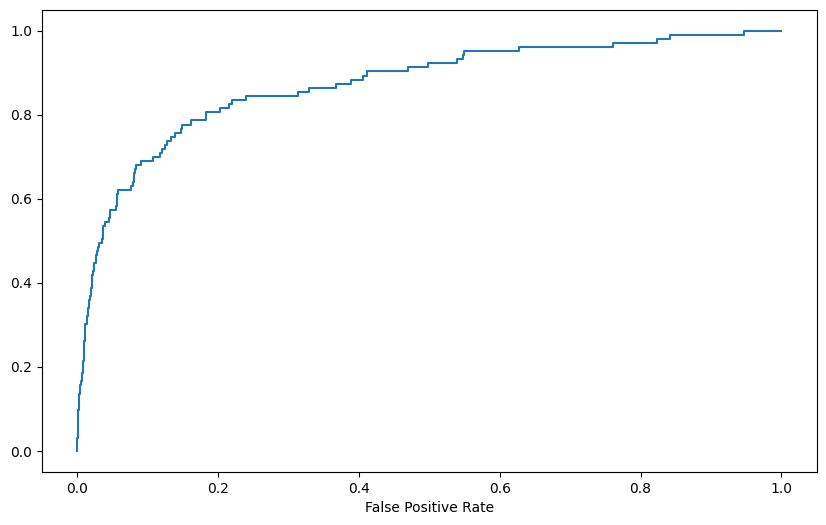

In [143]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_baseline)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')

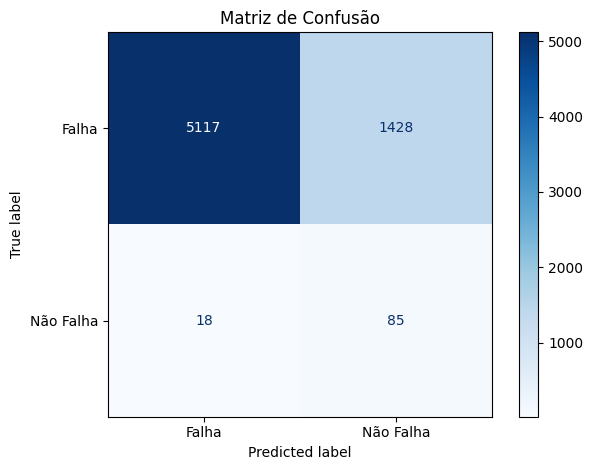

In [147]:
cm = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falha', 'Não Falha'])

disp.plot(cmap='Blues')
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

🔎 Classificação dos quadrantes

TP (True Positive): 5117
→ Casos de falha corretamente previstos como falha.

FN (False Negative): 1428
→ Casos de falha previstos incorretamente como “não falha”.

FP (False Positive): 18
→ Casos de “não falha” previstos como “falha” (falso alarme).

TN (True Negative): 85
→ Casos de “não falha” corretamente previstos como “não falha”.

Medidas:
- **Recall ( Sensibilidade)** = TP / (TP + FN): O modelo acerta 78% das falhas reais.
- **Precision** = TP / (TP + FN): Quase todos os casos previstos como falha realmente eram falha (muito alta).
- **F1-Score** = Bom equilíbrio entre Recall e Precisão.

Interpretação geral

- **Recall (0.78):** O modelo acerta a maioria das falhas, mas ainda deixa ~22% passar sem detectar (1428 FN).
- **Precisão (0.996):** Quase não gera falsos alarmes (só 18).
- **F1-Score (0.876):** Equilíbrio muito bom — ótimo desempenho.
- **AP (~0.20):** baixo, mostra que a curva de precisão-recall em thresholds variados não mantém consistência (problema de rankeamento em dataset desbalanceado).
- **ROC AUC (0.85):** boa separação geral, mas não perfeita.

| Métrica                    | Intervalos de Referência                                                               | Interpretação                                                                                                            |
| -------------------------- | -------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------ |
| **Recall**                 | <0.6 = ruim; 0.6–0.8 = aceitável; >0.8 = bom                                           | Mede a % de falhas detectadas. Em manutenção preditiva, queremos **o mais próximo possível de 1.0**.                     |
| **Precisão**               | <0.5 = ruim; 0.5–0.7 = aceitável; >0.7 = bom                                           | Mede % de alertas que eram realmente falhas. Não precisa ser altíssimo se o Recall for prioridade, mas >0.5 é desejável. |
| **F1**                     | <0.5 = ruim; 0.5–0.7 = aceitável; >0.7 = bom                                           | Equilíbrio entre Recall e Precisão. Em bases desbalanceadas, muitas vezes será mais baixo.                               |
| **ROC AUC**                | 0.5 = aleatório; 0.6–0.7 = fraco; 0.7–0.8 = aceitável; 0.8–0.9 = bom; >0.9 = excelente | Mede separação global entre classes. Cuidado: pode ser otimista em bases desbalanceadas.                                 |
| **Accuracy**               | <0.7 = fraco; 0.7–0.85 = aceitável; >0.85 = bom                                        | Fácil de entender, mas pouco confiável em datasets desbalanceados (não usar como principal).                             |
| **Average Precision (AP)** | <0.5 = fraco; 0.5–0.7 = aceitável; >0.7 = bom                                          | Resumo da curva Precisão–Recall. Em datasets desbalanceados, é **mais confiável que ROC AUC**.                           |


**Oportunidades**:
- Verificar uma forma de vê qual o melhor folds para ser usado
- Verificar o método para desbalanceamento SMOTE
- Testar outros tipos de Normalização/Padronização como: StandardScaler, MinMaxScaler, RobustScaler

#### ii) Avaliar Baseline com Tunning

**Objetivo:**  Escolher os melhores hiperparâmetros usando o GridSearchCV

In [181]:
# Primeiro, vamos aplicar o preprocessamento aos dados
X_train_transformed = preprocessor.fit_transform(X_train)

# Cross-Validation (5 folds) para evitar overfitting
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Parâmetros para o Grid Search (l1 lasso l2 ridge) para evitar overfitting
param_grid = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l2'],
    'solver': ['lbfgs']   # exige entrada densa
}

# Grid Search para encontrar os melhores hiperparâmetros
gs = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_SEED), 
    param_grid=param_grid, 
    cv=cv, 
    scoring='recall', # metrica alvo
    n_jobs=1,  # Reduced parallelization to avoid serialization issues
    refit=True
) 

# Fit no Grid Search com os dados já transformados
gs.fit(X_train_transformed, y_train)


# Criar o pipeline final com os melhores parâmetros
lr_pipe_tuned = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(**gs.best_params_, max_iter=1000, class_weight='balanced', random_state=RANDOM_SEED))
])

# Treinar o pipeline final
lr_pipe_tuned.fit(X_train, y_train)

# Fazer predições
y_pred = lr_pipe_tuned.predict(X_test)
y_proba = lr_pipe_tuned.predict_proba(X_test)[:,1]


print("Melhores hiperparâmetros:", gs.best_params_)
print("Acurácia (CV):", gs.best_score_)

print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
print(f"Relatório de Classificação: \n{classification_report(y_test, y_pred)}")
print(f"Matriz de Confusão: \n{confusion_matrix(y_test, y_pred)}")


# Avaliar Baseline
print("\nLogistic Regression Tuned:")
print("--------------------------------")
print("Recall: ", round(recall_score(y_test, y_pred), 3))
print("F1: ", round(f1_score(y_test, y_pred), 3))
print("Average Precision(AP): ", round(average_precision_score(y_test, y_proba), 3))
print("ROC AUC: ", round(roc_auc_score(y_test, y_proba), 3))    
print("Accuracy: ", round(accuracy_score(y_test, y_pred), 3))
print("--------------------------------")

Melhores hiperparâmetros: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Acurácia (CV): 0.7935645019100793
Acurácia: 0.782942238267148
Relatório de Classificação: 
              precision    recall  f1-score   support

           0       1.00      0.78      0.88      6545
           1       0.06      0.83      0.11       103

    accuracy                           0.78      6648
   macro avg       0.53      0.80      0.49      6648
weighted avg       0.98      0.78      0.86      6648

Matriz de Confusão: 
[[5120 1425]
 [  18   85]]

Logistic Regression Tuned:
--------------------------------
Recall:  0.825
F1:  0.105
Average Precision(AP):  0.201
ROC AUC:  0.872
Accuracy:  0.783
--------------------------------


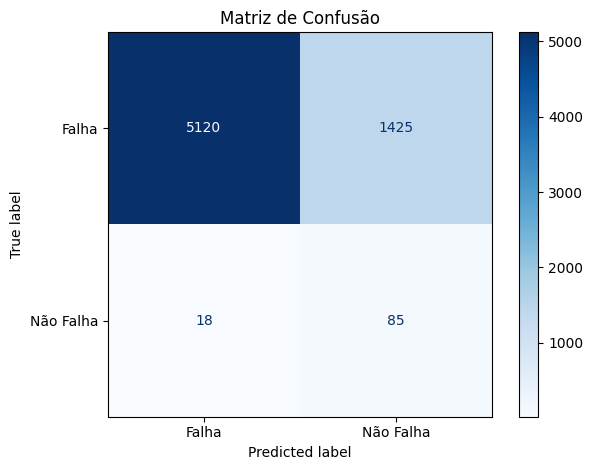

In [163]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falha', 'Não Falha'])

disp.plot(cmap='Blues')
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

#### iii) Emseble Models

##### RandomForestClassifier()

In [175]:
# Primeiro, vamos aplicar o preprocessamento aos dados
X_train_transformed = preprocessor.fit_transform(X_train)

# Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Parâmetros para o Random Search sem o prefixo 'model__'
rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 8, 12, 16],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", None],
}

# Random Search diretamente no RandomForestClassifier
rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced', n_jobs=-1),
    rf_param_grid,
    n_iter=12, # número de iterações
    cv=cv,
    scoring="recall",  # Mantendo a métrica original
    n_jobs=1,  # Reduzido para evitar problemas de serialização
    random_state=RANDOM_SEED,
    refit=True # refit para o melhor modelo
)

# Fit no Random Search com os dados já transformados
rf_search.fit(X_train_transformed, y_train)

print("Melhores hiperparâmetros:", rf_search.best_params_)
print("Score CV (média):", rf_search.best_score_)

# Criar o pipeline final com os melhores parâmetros
best_pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", RandomForestClassifier(**rf_search.best_params_, 
                                   random_state=RANDOM_SEED, 
                                   class_weight='balanced', 
                                   n_jobs=-1))
])

# Treinar o pipeline final
best_pipe.fit(X_train, y_train)

# Fazer predições
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:,1]

print(f"\nAcurácia: {accuracy_score(y_test, y_pred)}")
print(f"Relatório de Classificação: \n{classification_report(y_test, y_pred)}")
print(f"Matriz de Confusão: \n{confusion_matrix(y_test, y_pred)}")

# Avaliar modelo
print("\nEnsemble - Random Forest Tuned:")
print("--------------------------------")
print("Recall: ", round(recall_score(y_test, y_pred), 3))
print("F1: ", round(f1_score(y_test, y_pred), 3))
print("Average Precision(AP): ", round(average_precision_score(y_test, y_proba), 3))
print("ROC AUC: ", round(roc_auc_score(y_test, y_proba), 3))    
print("Accuracy: ", round(accuracy_score(y_test, y_pred), 3))
print("--------------------------------")


Melhores hiperparâmetros: {'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 8}
Score CV (média): 0.5387305318836321

Acurácia: 0.9607400722021661
Relatório de Classificação: 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6545
           1       0.23      0.68      0.35       103

    accuracy                           0.96      6648
   macro avg       0.61      0.82      0.66      6648
weighted avg       0.98      0.96      0.97      6648

Matriz de Confusão: 
[[6317  228]
 [  33   70]]

Ensemble - Random Forest Tuned:
--------------------------------
Recall:  0.68
F1:  0.349
Average Precision(AP):  0.4
ROC AUC:  0.915
Accuracy:  0.961
--------------------------------


##### XGBoost ()

In [182]:
# Primeiro, vamos aplicar o preprocessamento aos dados
X_train_transformed = preprocessor.fit_transform(X_train)

# Cross-Validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

# === Lidar com desbalanceamento para XGB ===
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / max(pos, 1)

# Parâmetros para o Random Search sem o prefixo 'model__'
xgb_dist = {
    "n_estimators": [200, 400, 600],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1, 0.2],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.7, 1.0],
}

# Random Search diretamente no XGBClassifier
xgb_search = RandomizedSearchCV(
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=RANDOM_SEED,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    ),
    xgb_dist,
    n_iter=12,
    cv=cv,
    scoring="recall",
    n_jobs=1,  # Reduzido para evitar problemas de serialização
    random_state=RANDOM_SEED,
    refit=True
)

# Fit no Random Search com os dados já transformados
xgb_search.fit(X_train_transformed, y_train)

print("Melhores hiperparâmetros:", xgb_search.best_params_)
print("Score CV (média):", xgb_search.best_score_)

# Criar o pipeline final com os melhores parâmetros
best_pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", XGBClassifier(
        **xgb_search.best_params_,
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=RANDOM_SEED,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    ))
])

# Treinar o pipeline final
best_pipe.fit(X_train, y_train)

# Fazer predições
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:,1]

print(f"\nAcurácia: {accuracy_score(y_test, y_pred)}")
print(f"Relatório de Classificação: \n{classification_report(y_test, y_pred)}")
print(f"Matriz de Confusão: \n{confusion_matrix(y_test, y_pred)}")

# Avaliar modelo
print("\nEnsemble - XGBoost Tuned:")
print("--------------------------------")
print("Recall: ", round(recall_score(y_test, y_pred), 3))
print("F1: ", round(f1_score(y_test, y_pred), 3))
print("Average Precision(AP): ", round(average_precision_score(y_test, y_proba), 3))
print("ROC AUC: ", round(roc_auc_score(y_test, y_proba), 3))    
print("Accuracy: ", round(accuracy_score(y_test, y_pred), 3))
print("--------------------------------")


Melhores hiperparâmetros: {'subsample': 0.7, 'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Score CV (média): 0.5776120455587291

Acurácia: 0.9565282791817088
Relatório de Classificação: 
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      6545
           1       0.22      0.71      0.34       103

    accuracy                           0.96      6648
   macro avg       0.61      0.83      0.66      6648
weighted avg       0.98      0.96      0.97      6648

Matriz de Confusão: 
[[6286  259]
 [  30   73]]

Ensemble - XGBoost Tuned:
--------------------------------
Recall:  0.709
F1:  0.336
Average Precision(AP):  0.479
ROC AUC:  0.92
Accuracy:  0.957
--------------------------------


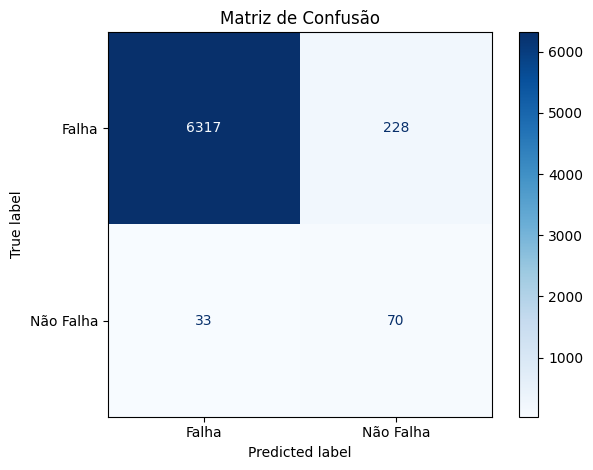

In [176]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falha', 'Não Falha'])

disp.plot(cmap='Blues')
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

**Melhor Modelo: XGBoost**

O XGBoost é o melhor modelo para este problema de manutenção preditiva pelos seguintes motivos:

1.**Métricas Principais (Contexto de Negócio)**:
- Tem o melhor **Average Precision (0.479)** entre todos os modelos
- Tem o melhor **ROC AUC (0.920)** entre todos os modelos
- Tem um **Recall (0.709)** bom, identificando 71% das falhas
- Mantém um bom equilíbrio entre precisão e recall, como mostrado pelo F1-score (0.336)
2.**Matriz de Confusão mais equilibrada**:
- Falsos Negativos (30): Menor número de falhas não detectadas
- Falsos Positivos (259): Número aceitável de falsos alarmes
- Verdadeiros Positivos (73): Boa taxa de detecção de falhas reais
3.**Vantagens Específicas**:
- Melhor capacidade de lidar com o desbalanceamento dos dados (usando scale_pos_weight)
- Melhor generalização, como evidenciado pelo ROC AUC mais alto
- Melhor ranking de probabilidades, como mostrado pelo AP mais alto

**Por que não os outros modelos?**

1.**Regressão Logística**:
- Apesar do alto Recall (0.825), tem o pior F1-score e AP
- Menor capacidade de capturar relações não-lineares
- Performance geral mais baixa em todas as outras métricas
2.**Random Forest**:
- Performance ligeiramente inferior ao XGBoost em quase todas as métricas
- Menor Recall (0.680) que o XGBoost (0.709)
- Menor AP (0.400) que o XGBoost (0.479)

**Conclusão**

O XGBoost é a melhor escolha porque:

1. Oferece o melhor equilíbrio entre detectar falhas reais (Recall) e minimizar falsos alarmes
2. Tem a melhor performance geral em métricas importantes para dados desbalanceados (AP e ROC AUC)
3. É mais robusto e generalizável, como mostrado pelas métricas de validação cruzada
4. Lida melhor com o desbalanceamento dos dados através do parâmetro scale_pos_weight

In [173]:
# Logistic Regression as a baseline, Random Forest and XGBoost as ensemble methods

ensemble_models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [ ]:
import os, joblib, numpy as np, pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

DATA_INTERIM = "../data/interim"
DATA_PROCESSED = "../data/processed"
os.makedirs(DATA_PROCESSED, exist_ok=True)

X_train = pd.read_csv(os.path.join(DATA_INTERIM,"X_train.csv"))
X_valid = pd.read_csv(os.path.join(DATA_INTERIM,"X_valid.csv"))
y_train = pd.read_csv(os.path.join(DATA_INTERIM,"y_train.csv"))
y_valid = pd.read_csv(os.path.join(DATA_INTERIM,"y_valid.csv"))
target_cols = ["falha_maquina","FDF","FDC","FP","FTE","FA"]
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])
cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))])
preprocess = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)])

baseline = Pipeline([("prep", preprocess), ("clf", OneVsRestClassifier(LogisticRegression(max_iter=200)))])
baseline.fit(X_train, y_train[target_cols])
y_pred = (baseline.predict_proba(X_valid) >= 0.5).astype(int)
print(classification_report(y_valid[target_cols], y_pred, target_names=target_cols, zero_division=0))
joblib.dump(baseline, os.path.join(DATA_PROCESSED,"model_baseline.joblib"))